In [170]:
class Value:
  def __init__(self, value, parents = (), op = '', label = ''):
    self.value = value
    self.grad = 0
    self.parents = set(parents)
    self.operation = op
    self.label = label
    self.backward = lambda:None

  def __repr__(self):
    return f'Value: {self.value}'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    val = Value(self.value + other.value, parents=(self, other), op='+')
    def backward():
      self.grad += 1.0 * val.grad
      other.grad += 1.0 * val.grad
    val.backward = backward
    return val

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    val = Value(self.value * other.value, parents=(self, other), op= '*')
    def backward():
      self.grad += other.value * val.grad
      other.grad += self.value * val.grad
    val.backward = backward
    return val

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)



  def tanh(self):
    x = self.value
    # x must always be a number.
    tan_of_x = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    val =  Value(tan_of_x, parents = (self, ), op = 'tanh')
    def backward():
      self.grad += val.grad * (1 - tan_of_x * tan_of_x)
    val.backward = backward
    return val

  def exp(self):
    x = self.value
    exp_value = Value(math.exp(x), parents = (self, ), op = 'exp')
    def backward():
      self.grad += exp_value.grad * exp_value.value
    exp_value.backward = backward
    return exp_value


  def __pow__(self, other):
    assert (isinstance(other, (int, float)), "only ints ot floats allowed...")
    x = self.value
    power_value = Value(x ** other, parents = (self, ), op = f'**{other}')
    def backward():
      self.grad += power_value.grad * other * (x ** (other - 1))
    power_value.backward = backward
    return power_value


  # dfs backwards to automaticlally apply backward and calucate gradients till inputs
  def backwards(self):
    visited = set() # its a directed graph ideally not needed
    topo_order = []
    def dfs(u):
      # print(u.label, u in visited)
      if u not in visited:
        visited.add(u)
        for p in u.parents:
          dfs(p)
        topo_order.append(u)

    dfs(self)

    self.grad = 1.0
    for node in reversed(topo_order):
      node.backward()

<>:68: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:68: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipython-input-3762957890.py:68: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (isinstance(other, (int, float)), "only ints ot floats allowed...")


In [ ]:
# @title
import math
import numpy as mp
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

In [ ]:
# @title
def trace(root):
  nodes, edges = set (), set()
  def build(kid:Value):
    if kid not in nodes:
      nodes.add(kid)
      for par in kid.parents:
        edges.add((par, kid))
        build(par)
  build(root)
  return nodes, edges

In [ ]:
# @title
def draw_dot(root: Value):
  dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})
  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = '{ %s | value %.4f | grad %.4f }' % (n.label, n.value, n.grad), shape='record')
    if n.operation:
      dot.node(name = uid + n.operation, label=n.operation)
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)
  return dot

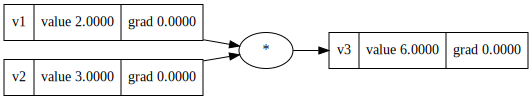

In [ ]:
draw_dot(v3)

In [ ]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88137, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1_x2w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



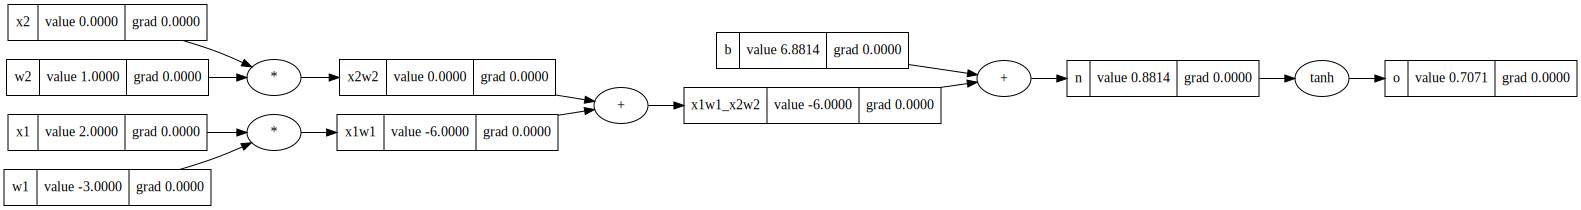

In [ ]:
draw_dot(o)

In [ ]:
o.backwards()

o
n
x1w1_x2w2
x1w1
w1
x1
x2w2
w2
x2
b


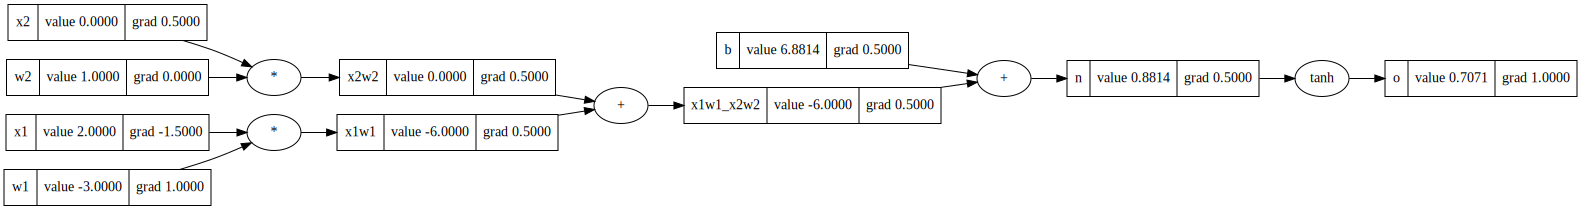

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0 # do/do

#do/dn = d(tan(n)) / dn = 1 - tan(n) * tan(n) = 1 - o * o
n.grad = 1 - o.value * o.value

# do / dx1w1_x2w2 = (do / dn) * (dn / dx1w1_x2w2)
# (dn / dx1w1_x2w2) = d (x1w1_x2w2 + b) / (x1w1_x2w2) = d(x1w1_x2w2) / d(x1w1_x2w2) + 0 = 1.0
# do / dx1w1_x2w2 = (do / dn) * 1.0 = do/dn = n.grad.
# do / db = n.grad by symmetry.

#do/x1w1 = do / dx1w1_x2w2  * (dx1w1_x2w2 ) /dx1w1 = n.grad

#do/x2w2 = do / dx1w1_x2w2  * (dx1w1_x2w2 ) /dx2w2 = n.grad

# do / x1 = do/dx1w1 * (dx1w1 / x1) = n.grad * w1
# do / w1 = n.grad * x1






In [ ]:
x1w1_x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
x1.grad = x1w1.grad * w1.value
w1.grad = x1w1.grad * x1.value

x2.grad = x2w2.grad * w2.value
w2.grad = x2w2.grad * x2.value


o




e


n
b
x1w1_x2w2
x1w1
w1
x1
x2w2
w2
x2



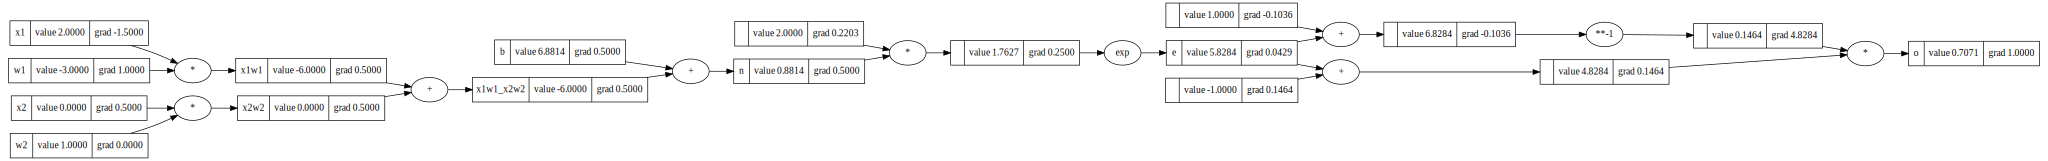

In [ ]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88137, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1_x2w2'
n = x1w1_x2w2 + b; n.label = 'n'

e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
o.backwards()
draw_dot(o)

# o = n.tanh(); o.label = 'o'


In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True;
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True;
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True;
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True;
b = torch.tensor([6.88137]).double(); b.requires_grad = True;

In [ ]:
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n);
print(o.data.item())
o.backward()
print(x1.grad.item())

NameError: name 'x1' is not defined

In [ ]:
# neural nets using our own library our own backwards function.

In [ ]:
import random

In [171]:
class Neuron:
  def __init__(self, num_inputs):
    self.weights = [Value(random.uniform(-0.9999, 0.9999))  for _ in range(num_inputs)]
    self.bias = Value(random.uniform(-0.9999, 0.9999))

  def __call__(self, x):
    # call this neuron on input x;
    # neural network function is w*x +b

    activation = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
    nonLinearity = activation.tanh()

    # then introduce non linearity
    return nonLinearity

  def paramters(self):
    return self.weights + [self.bias]

In [ ]:
x = [2.0, 3.0]
neuron = Neuron(2)
neuron(x)

Value: -0.8473520013144586

In [172]:
class Layer:
  def __init__(self, num_inputs, num_neurons):
    self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

  def __call__(self, x):
    # remember the output o hiddlen layer 1 is an input to the hidden layer 2
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs[0] if len(outputs) == 1 else outputs

  def parameters(self):
    #collate all parameters together.
    return [p for neuron in self.neurons for p in neuron.paramters()]

In [ ]:
layer = Layer(2, 3)
layer(x)

[Value: 0.8683850728769373,
 Value: 0.5689378860594245,
 Value: -0.8062562873240259]

In [ ]:
layer.parameters()

[Value: 0.4575782309653964,
 Value: 0.46663984422200677,
 Value: -0.9886013451488054,
 Value: 0.08771575925832598,
 Value: 0.47590106506429897,
 Value: -0.9571837296480346,
 Value: -0.39362328574170946,
 Value: -0.31555911029118977,
 Value: 0.6176861944950653]

In [173]:
class MultiLayerPerceptron:
  def __init__(self, num_inputs, neuron_layer_sizes):
    sizes = [num_inputs] + neuron_layer_sizes
    self.layers = [Layer(sizes[i], neuron_layer_sizes[i])for i in range(len(neuron_layer_sizes))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):

    return [p for layer in self.layers for p in layer.parameters()]

In [174]:
x = [2.0, 3.0, -1.0]
mlp = MultiLayerPerceptron(len(x), [4, 4, 1])
mlp(x).grad

0

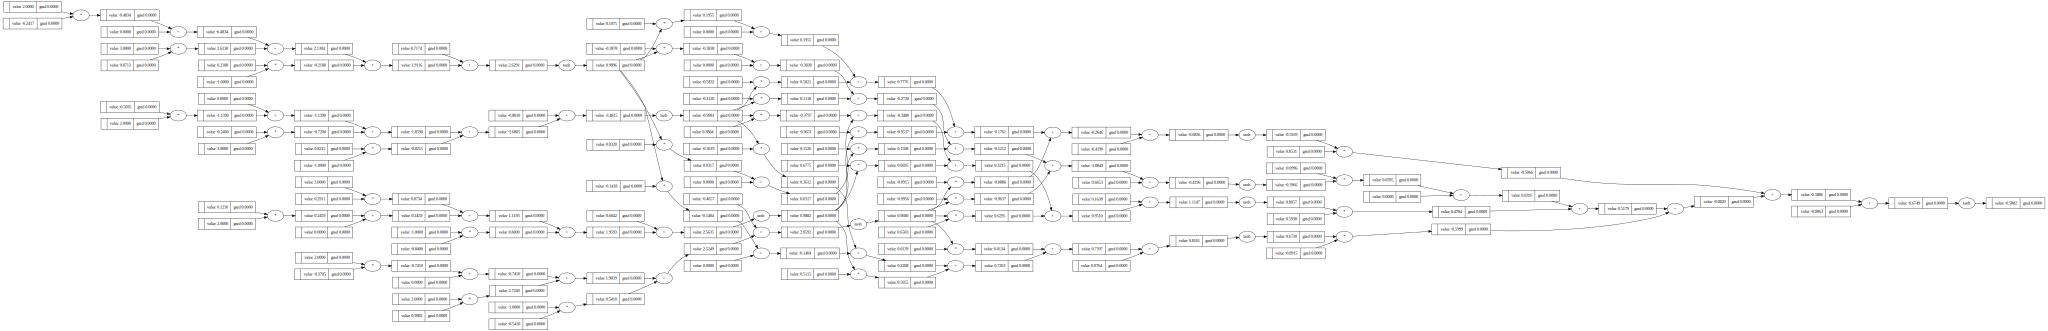

In [ ]:
draw_dot(mlp(x))

In [175]:
train_set_x = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
train_set_y = [1.0, -1.0, -1.0, 1.0]

In [176]:
y_pred = [mlp(x) for x in train_set_x]
y_pred

[Value: 0.9127848245027008,
 Value: 0.9410582965682122,
 Value: 0.9538005642454331,
 Value: 0.75007205695213]

In [177]:
def loss_function_mean_square_error(y_expected, y_predicted):
  return sum((y_pred - y_exp) **2 for y_exp, y_pred in zip(y_expected, y_predicted))


In [178]:
loss = loss_function_mean_square_error(train_set_y, y_pred)

In [179]:
loss.backwards()

In [180]:
mlp.layers[0].neurons[0].weights[0]

Value: 0.5623465204602189

In [181]:
mlp.layers[0].neurons[0].weights[0].grad

0.12079020294767213

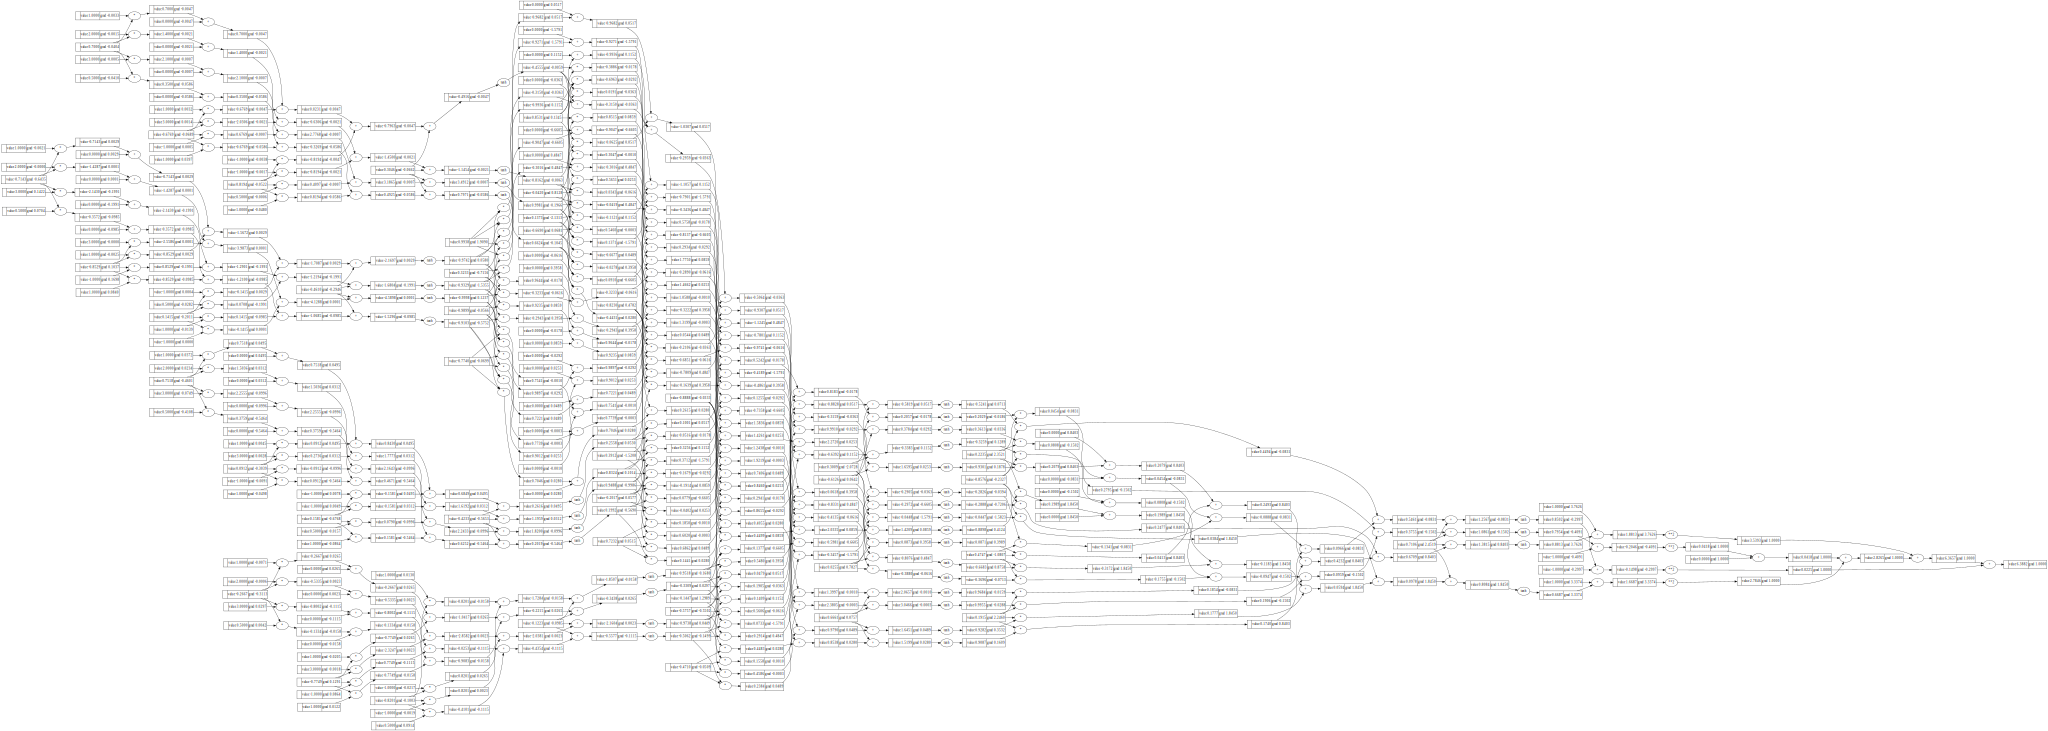

In [ ]:
draw_dot(loss)

In [184]:
params = mlp.parameters()
params

[Value: 0.5623465204602189,
 Value: -0.6134999522772405,
 Value: -0.6117421952369557,
 Value: -0.3934980236138771,
 Value: -0.8729166411708437,
 Value: 0.3330262624710483,
 Value: 0.4577745837070346,
 Value: 0.5791173243795309,
 Value: 0.8427979130231069,
 Value: -0.15898601448949123,
 Value: 0.9857510679207617,
 Value: -0.8205101297867299,
 Value: 0.9702642447204199,
 Value: 0.536431708905718,
 Value: 0.12016691416263181,
 Value: 0.8534995540330963,
 Value: -0.5940701997477341,
 Value: 0.20604999798732893,
 Value: 0.04186718987059912,
 Value: 0.7107532152543015,
 Value: 0.6801949567492016,
 Value: -0.7445121932705496,
 Value: -0.7189110809337214,
 Value: 0.81365071947692,
 Value: 0.283373399917072,
 Value: 0.19905718438415954,
 Value: 0.45231886173845215,
 Value: 0.7562767193529472,
 Value: 0.7987408288772853,
 Value: -0.5231642303904382,
 Value: -0.20900226452560056,
 Value: -0.2800055288953015,
 Value: 0.3401820516526133,
 Value: 0.13406982284115387,
 Value: 0.15736729900985313,
 Va

In [185]:
for p in mlp.parameters():
  p.value -= 0.01 * p.grad

In [187]:
params

[Value: 0.5611386184307422,
 Value: -0.6150542838442737,
 Value: -0.6100264881173871,
 Value: -0.394690821987807,
 Value: -0.8737221514890949,
 Value: 0.3323917169966336,
 Value: 0.458686254654255,
 Value: 0.5784926043036979,
 Value: 0.8426964269705628,
 Value: -0.15942926893752798,
 Value: 0.9837847835320035,
 Value: -0.8212420667835388,
 Value: 0.970286514945939,
 Value: 0.5364437218610465,
 Value: 0.12013896609738252,
 Value: 0.8535147491524817,
 Value: -0.5933871939131603,
 Value: 0.20537738704803013,
 Value: 0.042884955631152404,
 Value: 0.7114308850769117,
 Value: 0.680872705535823,
 Value: -0.7439906001426474,
 Value: -0.7197295398767672,
 Value: 0.8107970124553417,
 Value: 0.28302050585595273,
 Value: 0.19869295160303505,
 Value: 0.4521750833213677,
 Value: 0.756514874619793,
 Value: 0.7977920890204955,
 Value: -0.5243275182056362,
 Value: -0.21018641185475279,
 Value: -0.28182893547707,
 Value: 0.3418374823712182,
 Value: 0.1304147451058189,
 Value: 0.15550211539573366,
 Value

In [189]:
loss

Value: 7.655114419075226

In [242]:
#forward pass
class Value:
  def __init__(self, value, parents = (), op = '', label = ''):
    self.value = value
    self.grad = 0
    self.parents = set(parents)
    self.operation = op
    self.label = label
    self.backward = lambda:None

  def __repr__(self):
    return f'Value: {self.value}'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    val = Value(self.value + other.value, parents=(self, other), op='+')
    def backward():
      self.grad += 1.0 * val.grad
      other.grad += 1.0 * val.grad
    val.backward = backward
    return val

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    val = Value(self.value * other.value, parents=(self, other), op= '*')
    def backward():
      self.grad += other.value * val.grad
      other.grad += self.value * val.grad
    val.backward = backward
    return val

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)



  def tanh(self):
    x = self.value
    # x must always be a number.
    tan_of_x = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    val =  Value(tan_of_x, parents = (self, ), op = 'tanh')
    def backward():
      self.grad += val.grad * (1 - tan_of_x * tan_of_x)
    val.backward = backward
    return val

  def exp(self):
    x = self.value
    exp_value = Value(math.exp(x), parents = (self, ), op = 'exp')
    def backward():
      self.grad += exp_value.grad * exp_value.value
    exp_value.backward = backward
    return exp_value


  def __pow__(self, other):
    assert (isinstance(other, (int, float)), "only ints ot floats allowed...")
    x = self.value
    power_value = Value(x ** other, parents = (self, ), op = f'**{other}')
    def backward():
      self.grad += power_value.grad * other * (x ** (other - 1))
    power_value.backward = backward
    return power_value


  # dfs backwards to automaticlally apply backward and calucate gradients till inputs
  def backwards(self):
    visited = set() # its a directed graph ideally not needed
    topo_order = []
    def dfs(u):
      # print(u.label, u in visited)
      if u not in visited:
        visited.add(u)
        for p in u.parents:
          dfs(p)
        topo_order.append(u)

    dfs(self)

    self.grad = 1.0
    for node in reversed(topo_order):
      node.backward()

class Neuron:
  def __init__(self, num_inputs):
    self.weights = [Value(random.uniform(-0.9999, 0.9999))  for _ in range(num_inputs)]
    self.bias = Value(random.uniform(-0.9999, 0.9999))

  def __call__(self, x):
    # call this neuron on input x;
    # neural network function is w*x +b

    activation = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
    nonLinearity = activation.tanh()

    # then introduce non linearity
    return nonLinearity

  def paramters(self):
    return self.weights + [self.bias]

class Layer:
  def __init__(self, num_inputs, num_neurons):
    self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

  def __call__(self, x):
    # remember the output o hiddlen layer 1 is an input to the hidden layer 2
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs[0] if len(outputs) == 1 else outputs

  def parameters(self):
    #collate all parameters together.
    return [p for neuron in self.neurons for p in neuron.paramters()]


class MultiLayerPerceptron:
  def __init__(self, num_inputs, neuron_layer_sizes):
    sizes = [num_inputs] + neuron_layer_sizes
    self.layers = [Layer(sizes[i], neuron_layer_sizes[i])for i in range(len(neuron_layer_sizes))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):

    return [p for layer in self.layers for p in layer.parameters()]


def loss_function_mean_square_error(y_expected, y_predicted):
  return sum((y_pred - y_exp) **2 for y_exp, y_pred in zip(y_expected, y_predicted))

train_set_x = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
train_set_y = [1.0, -1.0, -1.0, 1.0]

mlp = MultiLayerPerceptron(len(train_set_x[0]), [4, 4, 1])

num_epochs = 2000;
learning_rate = 0.05
for iteration in range(num_epochs):

  y_pred = [mlp(x) for x in train_set_x]
  loss = loss_function_mean_square_error(train_set_y, y_pred)

  #backward pass
  for p in mlp.parameters():
    p.grad = 0.0 # zero grad before each backward.
  loss.backwards()

  #update
  for p in mlp.parameters():
    p.value -= learning_rate * p.grad

  #print
  print(loss, y_pred)


<>:69: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:69: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipython-input-1759000017.py:69: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (isinstance(other, (int, float)), "only ints ot floats allowed...")


Value: 4.462946654843091 [Value: -0.2408188221231703, Value: 0.04827630366221703, Value: -0.32243570267974536, Value: -0.16847709420644968]
Value: 3.4054943239443114 [Value: 0.15860529273351368, Value: 0.1822676350086907, Value: -0.252421042777845, Value: 0.13923393860012798]
Value: 2.7898613751541137 [Value: 0.1980829722007237, Value: 0.027828956200538844, Value: -0.4221692914673697, Value: 0.1302472967836907]
Value: 2.1269870357677316 [Value: 0.33981882689127624, Value: -0.07583519699034795, Value: -0.4726620864490177, Value: 0.25234901441224034]
Value: 1.4295069227895623 [Value: 0.42034963841890866, Value: -0.3325495375254479, Value: -0.5750221511264714, Value: 0.3163216478359087]
Value: 0.9069530329993897 [Value: 0.5654765060647108, Value: -0.47499868899192743, Value: -0.5981267955019938, Value: 0.4698925418710212]
Value: 0.6174948895529746 [Value: 0.6354703037400801, Value: -0.6079092437438561, Value: -0.649780352166348, Value: 0.5436842899621106]
Value: 0.45688488513996967 [Value